In [1]:
from typing import Tuple, List, Dict, Optional, Union

In [2]:
import torch
from torch import nn, tensor
import torchviz

In [3]:
from math import pi, sqrt, ceil, floor

In [4]:
import itertools
import functools

# Utilities

## Iterators

In [5]:
def pairwise(iterable):
    """
        s -> (s0,s1), (s1,s2), (s2, s3), ...
    """
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

# Torch Quantum Circuits

## States

In [6]:
def ket0(num_qubits: int) -> tensor:
    psi = torch.zeros(2**num_qubits)
    psi[0] = 1
    return psi.reshape(shape=[2]*num_qubits)

def ket1(num_qubits: int) -> tensor:
    psi = torch.zeros(2**num_qubits)
    psi[-1] = 1
    return psi.reshape(shape=[2]*num_qubits)

def ket(descr: str) -> tensor:
    out = None
    for s in descr:
        if s == "0":
            psi = tensor([1., 0.])
        elif s == "1":
            psi = tensor([0., 1.])
        elif s == "+":
            psi = normalize(tensor([1., 1.]))
        elif s == "-":
            psi = normalize(tensor([1., -1.]))
        else:
            assert False, "description has to be one of 0, 1, + or -"
            
        if out is None:
            out = psi
        else:
            out = torch.ger(out, psi).view(-1)
            
    return out.reshape(shape=[2]*len(descr))

def normalize(psi: tensor) -> tensor:
    return psi / psi.norm(p=2)

def num_state_qubits(psi: tensor) -> int:
    return len(psi.shape)

def num_operator_qubits(op: tensor) -> int:
    assert len(op.shape) % 2 == 0, "operator does not have same input and output indices"
    return len(op.shape) // 2

In [7]:
for s in ["00", "01", "10", "11"]:
    print(s, ket(s).view(-1))

00 tensor([1., 0., 0., 0.])
01 tensor([0., 1., 0., 0.])
10 tensor([0., 0., 1., 0.])
11 tensor([0., 0., 0., 1.])


In [8]:
ket("0+1").view(-1)

tensor([0.0000, 0.7071, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000])

In [9]:
normalize(torch.ones(4).reshape(2,2))

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]])

## Operations

In [10]:
EINSUM_ALPHABET = "abcdefghijklmnopqrstuvwxyz"

In [11]:
def squish_idcs_up(idcs: str) -> str:
    sorted_idcs = sorted(idcs)
    return "".join([
        EINSUM_ALPHABET[-i-1]
        for i in [ len(idcs)-1-sorted_idcs.index(c) for c in idcs ]
    ])

@functools.lru_cache(maxsize=10**6)
def einsum_indices(m: int, n: int, target_lanes: Tuple[int]) -> Tuple[str, str, str]:
    assert len(target_lanes) == m, "number of target and operator indices don't match"
    assert torch.all( tensor(target_lanes) < n ), "target lanes not present in state"
    
    idcs_op = squish_idcs_up("".join( EINSUM_ALPHABET[-l-1] for l in target_lanes )) + "".join( EINSUM_ALPHABET[r] for r in target_lanes )
    idcs_target = EINSUM_ALPHABET[:n]
    
    idcs_result = ""
    idcs_op_lut = dict(zip(idcs_op[m:], idcs_op[:m]))  # lookup table from operator's right to operator's left indices
    for c in idcs_target:
        if c in idcs_op_lut:
            idcs_result += idcs_op_lut[c]
        else:
            idcs_result += c
            
    return (idcs_op, idcs_target, idcs_result)

In [12]:
squish_idcs_up("zkxm")

'zwyx'

In [13]:
def apply(op: tensor, psi: tensor, target_lanes: List[int], verbose: bool = False) -> tensor:
    n = num_state_qubits(psi)
    m = num_operator_qubits(op)
    
    idcs_op, idcs_target, idcs_result = einsum_indices(m, n, tuple(target_lanes))
    idcs_einsum = f"{idcs_op},{idcs_target}->{idcs_result}"
    verbose and print(idcs_einsum)
    
    return torch.einsum(idcs_einsum, op, psi)

def dot(a: tensor, b: tensor) -> tensor:
    idcs_einsum = f"{EINSUM_ALPHABET[:len(a.shape)]},{EINSUM_ALPHABET[:len(b.shape)]}->"
    return torch.einsum(idcs_einsum, a, b)

In [14]:
# for tests see below at Gate Layers

In [15]:
def probabilities(psi: tensor, measured_lanes: Optional[List[int]] = None, verbose: bool = False):
    if measured_lanes is None:
        measured_lanes = range(len(psi.shape))
    n = num_state_qubits(psi)
    
    idcs_kept = "".join( EINSUM_ALPHABET[i] for i in measured_lanes )
    idcs_einsum = f"{ EINSUM_ALPHABET[:n] },{ EINSUM_ALPHABET[:n] }->{idcs_kept}"
    verbose and print(idcs_einsum)
    return torch.einsum(idcs_einsum, psi, psi).reshape(-1)

In [16]:
probabilities(ket("00"), [0, 1])

tensor([1., 0., 0., 0.])

In [17]:
probabilities(ket("11"), [0])

tensor([0., 1.])

In [18]:
probabilities(ket0(5), [1])

tensor([1., 0.])

In [19]:
# EPR pair
psiminus = normalize(tensor([[1., 0.], [0., -1.]]))
print(psiminus)
probabilities(psiminus, [0, 1])

tensor([[ 0.7071,  0.0000],
        [ 0.0000, -0.7071]])


tensor([0.5000, 0.0000, 0.0000, 0.5000])

In [20]:
probabilities(psiminus, [1])

tensor([0.5000, 0.5000])

## Gate Layers

In [21]:
import copy

In [22]:
_gate_layer_id = 0
class GateLayer(nn.Module):    
    def __init__(self):
        super().__init__()
        
        self.dagger = False
        
        global _gate_layer_id
        _gate_layer_id += 1
        self._id = _gate_layer_id
    
    @property
    def Ut(self) -> tensor:
        U = self.U
        shape = U.shape
        dim = tensor(U.shape[:len(U.shape)//2]).prod()  # product of half of the dimensions
        return U.reshape(dim, dim).T.reshape(shape)
    
    @property
    def T(self):
        new = copy.copy(self)
        new.dagger = not new.dagger
        return new
    
    def forward(self, psi: tensor, normalize_afterwards: bool = False) -> tensor:
        psi = apply(self.U if not self.dagger else self.Ut, psi, self.lanes)
        return psi if not normalize_afterwards else normalize(psi)
    
    def extra_repr(self):
        return f"lanes={self.lanes}, id={self._id}{', †' if self.dagger else ''}"
    
    def to_mat(self):
        n = num_operator_qubits(self.U)
        basis = list(itertools.product("01", repeat=n))
        
        out = tensor([[
            dot(ket("".join(x)), self.forward(ket("".join(y))))
            for x in basis
        ] for y in basis
        ])

        return out

### X

In [23]:
class XLayer(GateLayer):
    def __init__(self, target_lane: int):
        super().__init__()
        self.lanes = [target_lane]
        self.U = tensor(
              [[ 0.,  1. ],
               [ 1.,  0. ]]
        )

In [24]:
XLayer(0).to_mat()

tensor([[0., 1.],
        [1., 0.]])

### H

In [25]:
class HLayer(GateLayer):
    def __init__(self, target_lane: int):
        super().__init__()
        self.lanes = [target_lane]
        self.U = tensor(
              [[ 1.,  1. ],
               [ 1., -1. ]]
        ) / sqrt(2.)

In [26]:
HLayer(0).to_mat()

tensor([[ 0.7071,  0.7071],
        [ 0.7071, -0.7071]])

### rY

In [27]:
class rYLayer(GateLayer):
    def __init__(self, target_lane: int, initial_θ: float = 1.):
        super().__init__()
        
        self.lanes = [target_lane]
        self.θ = nn.Parameter(tensor(initial_θ, requires_grad=True))
        self.register_parameter("θ", self.θ)
        
    @property
    def U(self) -> tensor:
        # note: these matrices are TRANSPOSED! in this notation
        θ = self.θ
        return torch.stack([
            torch.stack([ (.5*θ).cos(), (-.5*θ).sin() ]),
            torch.stack([ (.5*θ).sin(),  (.5*θ).cos() ])
        ])

In [28]:
# the transposition is visible here, where we get the correct shape
rYLayer(0, pi/2).to_mat()

tensor([[ 0.7071,  0.7071],
        [-0.7071,  0.7071]])

In [29]:
rYLayer(0, pi/2).T.to_mat()

tensor([[ 0.7071, -0.7071],
        [ 0.7071,  0.7071]])

In [30]:
list(rYLayer(2).named_parameters())

[('θ',
  Parameter containing:
  tensor(1., requires_grad=True))]

In [31]:
apply(rYLayer(2).U, ket0(3), [0], verbose=True)

za,abc->zbc


tensor([[[0.8776, 0.0000],
         [0.0000, 0.0000]],

        [[0.4794, 0.0000],
         [0.0000, 0.0000]]], grad_fn=<ViewBackward>)

In [32]:
apply(rYLayer(2).U, ket0(3), [2], True)

zc,abc->abz


tensor([[[0.8776, 0.4794],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]]], grad_fn=<ViewBackward>)

In [33]:
# parameter sharing works as expected
foo = rYLayer(2)
list(nn.Sequential(foo, foo.T).named_parameters())

[('0.θ',
  Parameter containing:
  tensor(1., requires_grad=True))]

In [34]:
# and here we have two separate parameters
list(nn.Sequential(foo, rYLayer(2)).named_parameters())

[('0.θ',
  Parameter containing:
  tensor(1., requires_grad=True)),
 ('1.θ',
  Parameter containing:
  tensor(1., requires_grad=True))]

### crY

In [35]:
class crYLayer(GateLayer):
    def __init__(self, control_lane: int, target_lane: int, initial_θ: float = 1.):
        super().__init__()
        
        self.lanes = [control_lane, target_lane]
        self.θ = nn.Parameter(tensor(initial_θ, requires_grad=True))
        self.register_parameter("θ", self.θ)
    
    @property
    def U(self) -> tensor:
        # note: these matrices are TRANSPOSED! in this notation
        θ = self.θ
        return torch.stack([
            torch.stack([ tensor([1., 0.]), tensor([ 0., 0.]) ]),
            torch.stack([ tensor([0., 1.]), tensor([ 0., 0.]) ]),

            torch.stack([ tensor([0., 0.]), torch.stack([ (.5*θ).cos(), (-.5*θ).sin() ]) ]),  # TRANSPOSED again, see comment above
            torch.stack([ tensor([0., 0.]), torch.stack([ (.5*θ).sin(),  (.5*θ).cos() ]) ]),     
        ]).reshape(2, 2, 2, 2)

In [36]:
crYLayer(0, 1, initial_θ=pi/2).to_mat()

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.7071,  0.7071],
        [ 0.0000,  0.0000, -0.7071,  0.7071]])

In [37]:
list(crYLayer(1, 2).named_parameters())

[('θ',
  Parameter containing:
  tensor(1., requires_grad=True))]

In [38]:
# controlled gate has no action on |0> control
crYLayer(0, 1).forward(ket("00")).view(-1)

tensor([1., 0., 0., 0.], grad_fn=<ViewBackward>)

In [39]:
# controlled gate has action on |1> control
crYLayer(0, 1, initial_θ=-pi/4).forward(ket("10")).view(-1)

tensor([ 0.0000,  0.0000,  0.9239, -0.3827], grad_fn=<ViewBackward>)

In [40]:
foo = apply(crYLayer(0, 1, initial_θ=1.).U, apply(HLayer(0).U, ket0(2), [0], verbose=True), [1, 0], verbose=True).view(-1)
foo

za,ab->zb
yzba,ab->zy


tensor([0.7071, 0.0000, 0.7071, 0.0000], grad_fn=<ViewBackward>)

In [41]:
probabilities(foo)

tensor([0.5000, 0.0000, 0.5000, 0.0000], grad_fn=<ViewBackward>)

### cYpi4Z = c(-iY)

In [42]:
class cmiYLayer(GateLayer):
    def __init__(self, control_lane: int, target_lane: int):
        super().__init__()
        
        self.lanes = [control_lane, target_lane]
        
        # note: these matrices are TRANSPOSED! in this notation
        self.U = tensor(
              [[ 1.,  0.,  0.,  0.],
               [ 0.,  1.,  0.,  0.],
               [ 0.,  0.,  0.,  1.],
               [ 0.,  0., -1.,  0.]]
        ).T.reshape(2, 2, 2, 2)

In [43]:
cmiYLayer(0, 1).to_mat()

tensor([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [ 0.,  0., -1.,  0.]])

In [44]:
apply(cmiYLayer(0, 1).U, ket("01"), [1, 0], verbose=True).reshape(-1)

yzba,ab->zy


tensor([0., 0., 0., 1.])

In [45]:
tensor([[1, 2], [3, 4]], dtype=torch.float).view(-1)

tensor([1., 2., 3., 4.])

In [46]:
cmiYLayer(0, 1).forward(tensor([[1, 2], [3, 4]], dtype=torch.float)).view(-1)

tensor([ 1.,  2., -4.,  3.])

In [47]:
cmiYLayer(0, 1).T.forward(tensor([[1, 2], [3, 4]], dtype=torch.float)).view(-1)

tensor([ 1.,  2.,  4., -3.])

### Postselection

In [48]:
class PostselectLayer(GateLayer):
    def __init__(self, target_lane: int, on: int):
        super().__init__()
        self.on = on
        self.lanes = [target_lane]
        self.U = torch.zeros(4).reshape(2, 2)
        self.U[on, on] = 1.
        
    def forward(self, psi: tensor) -> tensor:
        return super().forward(psi, normalize_afterwards=True)
    
    def extra_repr(self):
        return super().extra_repr() + f", on={self.on}"    

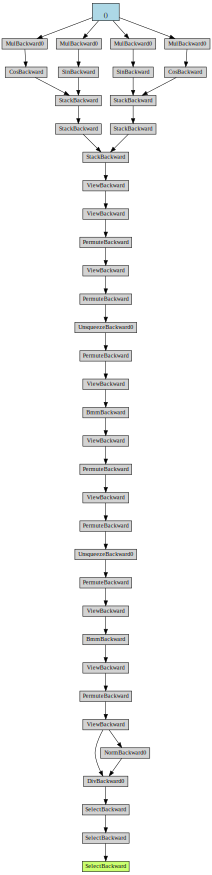

In [49]:
temp = PostselectLayer(0, 0).forward(
    crYLayer(1, 2).T.forward(ket0(3))
)[0][1][0]
temp.backward()
torchviz.make_dot(temp)

## Compound Layers

In [50]:
def _T_gate_list(gates: List[GateLayer]) -> List[GateLayer]:
    return [ g.T for g in reversed(gates) ]

In [51]:
class CompoundLayer(nn.Module):
    def forward(self, psi: tensor) -> tensor:
        return self.gates.forward(psi)

In [52]:
class BitFlipLayer(CompoundLayer):
    def __init__(self, target_lanes: List[int]):
        super().__init__()
        self.gates = nn.Sequential(*[ XLayer(i) for i in target_lanes ])

In [53]:
BitFlipLayer([1, 3, 5])

BitFlipLayer(
  (gates): Sequential(
    (0): XLayer(lanes=[1], id=22)
    (1): XLayer(lanes=[3], id=23)
    (2): XLayer(lanes=[5], id=24)
  )
)

In [54]:
class PostselectManyLayer(CompoundLayer):
    def __init__(self, target_lanes: List[int], on: List[int]):
        super().__init__()
        self.gates = nn.Sequential(*[ PostselectLayer(t, w) for t, w in zip(target_lanes, on) ])

In [55]:
PostselectManyLayer(range(3), [1, 1, 0])

PostselectManyLayer(
  (gates): Sequential(
    (0): PostselectLayer(lanes=[0], id=25, on=1)
    (1): PostselectLayer(lanes=[1], id=26, on=1)
    (2): PostselectLayer(lanes=[2], id=27, on=0)
  )
)

In [56]:
class UnitaryLayer(CompoundLayer):
    def __init__(self, workspace_size: int):
        super().__init__()     
        self.gates = nn.Sequential(*[ rYLayer(i) for i in range(workspace_size) ])  # we reverse the order so to have the same lane order as in qiskit
        
    def extra_repr(self):
        return f"workspace_size={len(self.gates)}"

In [57]:
list(UnitaryLayer(3).named_parameters(recurse=True))

[('gates.0.θ',
  Parameter containing:
  tensor(1., requires_grad=True)),
 ('gates.1.θ',
  Parameter containing:
  tensor(1., requires_grad=True)),
 ('gates.2.θ',
  Parameter containing:
  tensor(1., requires_grad=True))]

In [58]:
probabilities(UnitaryLayer(3).forward(ket("000")), measured_lanes=range(3))

tensor([0.4568, 0.1363, 0.1363, 0.0407, 0.1363, 0.0407, 0.0407, 0.0121],
       grad_fn=<UnsafeViewBackward>)

In [59]:
class QuantumNeuronLayer(CompoundLayer):
    def __init__(self, workspace_size: int, outlane: int, order: int = 2):
        super().__init__()
        
        self.workspace_size = workspace_size
        self.outlane = outlane
        self.order = order
        
        self.ancilla_idcs = ancilla_idcs = list(range(workspace_size, workspace_size + order))
                
        # precompute parametrized gates as they need to share weights
        self._param_gates = []        
        for i in range(self.workspace_size):
            if i == self.outlane: continue
            self._param_gates.append(crYLayer(i, self.ancilla_idcs[0]))
        self._param_gates.append(rYLayer(self.ancilla_idcs[0]))
        
        # assemble circuit gate layers
        _gates = []
        self._append_gates_recursive(_gates, self.order-1, dagger=False)
        self.gates = nn.Sequential(*_gates)
        
        
    def param_gates(self, dagger: bool) -> List[GateLayer]:        
        return self._param_gates if not dagger else _T_gate_list(self._param_gates)
        
        
    def static_gates(self, idx: int, dagger: bool) -> List[GateLayer]:
        static_lanes = [ *self.ancilla_idcs, self.outlane ]
        static_gates = [ cmiYLayer(static_lanes[idx], static_lanes[idx+1]) ]
        
        return static_gates if not dagger else _T_gate_list(static_gates)
    
    
    def _append_gates_recursive(self, _gates: List[GateLayer], recidx: int, dagger: bool):
        if recidx == 0:
            _gates += self.param_gates(dagger=False)
            _gates += self.static_gates(0, dagger)
            _gates += self.param_gates(dagger=True)
        
        else:
            self._append_gates_recursive(_gates, recidx-1, dagger=False)
            _gates += self.static_gates(recidx, dagger)
            self._append_gates_recursive(_gates, recidx-1, dagger=True)
            
        # postselect measurement outcome 0 on corresponding ancilla
        ancilla_to_postselect_on = self.ancilla_idcs[recidx]
        _gates.append(PostselectLayer(ancilla_to_postselect_on, on=0))
        
        
    def extra_repr(self):
        return f"workspace_size={self.workspace_size}, outlane={self.outlane}, order={self.order}"    

In [60]:
l = QuantumNeuronLayer(2, 0, order=2)
for p, v in zip(l.parameters(), [pi/4, pi/8]):
    with torch.no_grad():
        print(p, v)
        p.fill_(v)
l.forward(ket("10+-")).reshape(-1)

Parameter containing:
tensor(1., requires_grad=True) 0.7853981633974483
Parameter containing:
tensor(1., requires_grad=True) 0.39269908169872414


tensor([0.0214, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9998,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       grad_fn=<UnsafeViewBackward>)

In [61]:
# consistency with torch

psi = normalize(tensor([1., 0., 1, 1., 0, 0., 0, 1.]).reshape(2, 2, 2))
print(probabilities(psi))

layer1 = crYLayer(1, 2, initial_θ=pi/4)
layer2 = rYLayer(2, initial_θ=pi/8)
layer3 = cmiYLayer(2, 0)
layer4 = rYLayer(2, initial_θ=-pi/8)
layer5 = crYLayer(1, 2, initial_θ=-pi/4)
for l in [layer1, layer2, layer3, layer4, layer5]:
    psi = l.forward(psi)
    print(l, "\n  ", psi.reshape(-1))
    

psi = PostselectLayer(2, on=0).forward(psi)
print(probabilities(psi))

tensor([0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500])
crYLayer(lanes=[1, 2], id=42) 
   tensor([ 0.5000,  0.0000,  0.2706,  0.6533,  0.0000,  0.0000, -0.1913,  0.4619],
       grad_fn=<UnsafeViewBackward>)
rYLayer(lanes=[2], id=43) 
   tensor([ 0.4904,  0.0975,  0.1379,  0.6935,  0.0000,  0.0000, -0.2778,  0.4157],
       grad_fn=<UnsafeViewBackward>)
cmiYLayer(lanes=[2, 0], id=44) 
   tensor([ 0.4904,  0.0000,  0.1379, -0.4157,  0.0000,  0.0975, -0.2778,  0.6935],
       grad_fn=<UnsafeViewBackward>)
rYLayer(lanes=[2], id=45) 
   tensor([ 0.4810, -0.0957,  0.0542, -0.4347,  0.0190,  0.0957, -0.1371,  0.7344],
       grad_fn=<UnsafeViewBackward>)
crYLayer(lanes=[1, 2], id=46) 
   tensor([ 0.4810, -0.0957, -0.1163, -0.4223,  0.0190,  0.0957,  0.1543,  0.7310],
       grad_fn=<UnsafeViewBackward>)
tensor([0.8599, 0.0000, 0.0502, 0.0000, 0.0013, 0.0000, 0.0885, 0.0000],
       grad_fn=<UnsafeViewBackward>)


In [62]:
layer3 = rYLayer(2, initial_θ=pi/8)
psi = layer2.forward(psi)
probabilities(psi)

tensor([8.2715e-01, 3.2727e-02, 4.8336e-02, 1.9125e-03, 1.2949e-03, 5.1233e-05,
        8.5161e-02, 3.3695e-03], grad_fn=<UnsafeViewBackward>)

In [63]:
psi = cmiYLayer(2, 0).forward(psi)
probabilities(psi)

tensor([8.2715e-01, 5.1233e-05, 4.8336e-02, 3.3695e-03, 1.2949e-03, 3.2727e-02,
        8.5161e-02, 1.9125e-03], grad_fn=<UnsafeViewBackward>)

In [64]:
psi = layer2.T.forward(psi)
psi = layer1.T.forward(psi)
probabilities(psi)

tensor([0.7932, 0.0340, 0.0462, 0.0055, 0.0050, 0.0290, 0.0477, 0.0394],
       grad_fn=<UnsafeViewBackward>)

In [65]:
probabilities(PostselectLayer(2, on=0).forward(psi), [0, 1, 2])

tensor([0.8891, 0.0000, 0.0518, 0.0000, 0.0056, 0.0000, 0.0534, 0.0000],
       grad_fn=<UnsafeViewBackward>)

In [66]:
probabilities(QuantumNeuronLayer(2, 0, order=1).forward(UnitaryLayer(2).forward(ket("0000"))), [0, 1])

tensor([0.3897, 0.0025, 0.3970, 0.2107], grad_fn=<ViewBackward>)

In [67]:
probabilities(QuantumNeuronLayer(2, 0, order=2).forward(UnitaryLayer(2).forward(ket("0000"))), [0, 1])

tensor([0.5679, 0.0190, 0.2533, 0.1598], grad_fn=<ViewBackward>)

In [68]:
# %timeit probabilities(QuantumNeuronLayer(6, 0, 2).forward(UnitaryLayer(6).forward(ket0(8))), [0, 1])

## RVQE Cell

In [69]:
class RVQECell(nn.Module):
    def __init__(self, workspace_size: int, stages: int, order: int = 2):
        super().__init__()
        
        self.workspace_size = workspace_size
        self.order = order
        
        self.gates = nn.Sequential(*[
            nn.Sequential( 
                UnitaryLayer(workspace_size),
                *[ QuantumNeuronLayer(workspace_size, outlane, order) for outlane in range(workspace_size) ]
            ) for _ in range(stages)
        ])
        
    @property
    def num_qubits(self) -> int:
        return self.workspace_size + self.order
        
    def forward(self, psi: tensor, input: List[int]) -> Tuple[tensor, tensor]:
        # we assume psi has its input lanes reset to 0
        input_lanes = range(len(input))
        psi = BitFlipLayer([ i for i in input_lanes if input[i] == 1 ]).forward(psi)
        psi = self.gates.forward(psi)
        
        return probabilities(psi, input_lanes), psi

In [70]:
RVQECell(1, stages=1, order=2)

RVQECell(
  (gates): Sequential(
    (0): Sequential(
      (0): UnitaryLayer(
        workspace_size=1
        (gates): Sequential(
          (0): rYLayer(lanes=[0], id=67)
        )
      )
      (1): QuantumNeuronLayer(
        workspace_size=1, outlane=0, order=2
        (gates): Sequential(
          (0): rYLayer(lanes=[1], id=68)
          (1): cmiYLayer(lanes=[1, 2], id=69)
          (2): rYLayer(lanes=[1], id=68, †)
          (3): PostselectLayer(lanes=[1], id=70, on=0)
          (4): cmiYLayer(lanes=[2, 0], id=71)
          (5): rYLayer(lanes=[1], id=68)
          (6): cmiYLayer(lanes=[1, 2], id=72, †)
          (7): rYLayer(lanes=[1], id=68, †)
          (8): PostselectLayer(lanes=[1], id=73, on=0)
          (9): PostselectLayer(lanes=[2], id=74, on=0)
        )
      )
    )
  )
)

In [71]:
# %timeit RVQECell(6, 3).forward(ket0(8), [1, 1])

In [72]:
len(list(RVQECell(6, 3).parameters()))

126

In [73]:
temp = RVQECell(3, 1).forward(ket0(5), [1])[0][0]
temp.backward()
torchviz.make_dot(temp);

# RVQE

## Utility Functions

In [74]:
def bitword_to_int(lst: Union[List[int], tensor]) -> int:
    if not isinstance(lst, list):
        lst = lst.tolist()
        
    return int("".join(str(n) for n in lst), 2)

def bitword_to_onehot(lst: List[int], width: int) -> tensor:
    ret = torch.zeros(2**width)
    idx = bitword_to_int(lst)
    ret[idx] = 1.
    return ret

In [75]:
bitword_to_onehot(tensor([0, 0, 1]), 3)

tensor([0., 1., 0., 0., 0., 0., 0., 0.])

In [76]:
bitword_to_int(tensor([0, 1, 1]))

3

In [77]:
def int_to_bitword_str(label: int, width: int) -> str:
    return bin(label)[2:].rjust(width, "0")

def int_to_bitword(label: int, width: int) -> List[int]:
    return [ int(c) for c in int_to_bitword_str(label, width) ]

In [78]:
int_to_bitword(12, 10)

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]

In [79]:
bin(tensor([1, 2])[0])

'0b1'

In [80]:
def bitword_to_str(lst: Union[List[int], tensor]) -> str:
    return int_to_bitword_str(bitword_to_int(lst), len(lst))

In [81]:
bitword_to_str([1, 1, 1, 0])

'1110'

## RVQE Module

In [82]:
tensor([.5, .4, .1]).dim()

1

In [83]:
class RVQE(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.cell = RVQECell(*args, **kwargs)
        
    def forward(self, inputs: tensor, postselect_measurement: bool = True) -> Tuple[tensor, list]:
        # batched call; return stacked result
        if inputs.dim() == 3:
            batch_measured_seq = []
            batch_probs = []
            for inpt in inputs:
                probs, measured_seq = self.forward(inpt, postselect_measurement)
                batch_probs.append(probs)
                batch_measured_seq.append(measured_seq)
            return torch.stack(batch_probs), torch.stack(batch_measured_seq)
        
        # normal call
        assert inputs.dim() == 2, "inputs have to have dimension 3 (1st batch) or 2 (list of int lists)"
        
        num_qubits = self.cell.num_qubits
        input_size = len(inputs[0])
        input_lanes = range(input_size)
        
        psi = ket0(num_qubits)
        probs = []
        measured_seq = []
        
        for inpt, trgt in pairwise(inputs):   
            assert len(inpt) == input_size and len(trgt) == input_size, "inputs all have to be the same length"
            
            p, psi = self.cell.forward(psi, inpt)
            probs.append(p)
            
            # measure output
            if postselect_measurement:
                measure = trgt
            else:
                output_distribution = torch.distributions.Categorical(probs=p)
                measure = tensor(int_to_bitword(output_distribution.sample(), width=input_size))
                
            measured_seq.append(measure)
            psi = PostselectManyLayer(input_lanes, measure).forward(psi)
            
            # reset qubits
            psi = BitFlipLayer([ i for i in input_lanes if measure[i] ]).forward(psi)
            
        return torch.stack(probs), torch.stack(measured_seq)

In [84]:
RVQE(workspace_size=6, stages=3).forward(torch.stack([
    tensor( [[1, 0, 1], [1, 1, 1], [1, 0, 0]] ),
    tensor( [[1, 1, 1], [1, 0, 1], [0, 0, 0]] ),
]))

(tensor([[[0.0254, 0.0438, 0.5976, 0.0172, 0.0421, 0.2275, 0.0137, 0.0327],
          [0.0141, 0.0738, 0.0255, 0.0100, 0.0027, 0.0027, 0.0048, 0.8664]],
 
         [[0.0093, 0.2178, 0.2304, 0.0256, 0.0434, 0.0381, 0.0132, 0.4222],
          [0.0361, 0.0605, 0.3498, 0.0275, 0.0092, 0.1237, 0.0225, 0.3708]]],
        grad_fn=<StackBackward>),
 tensor([[[1, 1, 1],
          [1, 0, 0]],
 
         [[1, 0, 1],
          [0, 0, 0]]]))

In [85]:
RVQE(workspace_size=2, stages=1, order=2)

RVQE(
  (cell): RVQECell(
    (gates): Sequential(
      (0): Sequential(
        (0): UnitaryLayer(
          workspace_size=2
          (gates): Sequential(
            (0): rYLayer(lanes=[0], id=602)
            (1): rYLayer(lanes=[1], id=603)
          )
        )
        (1): QuantumNeuronLayer(
          workspace_size=2, outlane=0, order=2
          (gates): Sequential(
            (0): crYLayer(lanes=[1, 2], id=604)
            (1): rYLayer(lanes=[2], id=605)
            (2): cmiYLayer(lanes=[2, 3], id=606)
            (3): rYLayer(lanes=[2], id=605, †)
            (4): crYLayer(lanes=[1, 2], id=604, †)
            (5): PostselectLayer(lanes=[2], id=607, on=0)
            (6): cmiYLayer(lanes=[3, 0], id=608)
            (7): crYLayer(lanes=[1, 2], id=604)
            (8): rYLayer(lanes=[2], id=605)
            (9): cmiYLayer(lanes=[2, 3], id=609, †)
            (10): rYLayer(lanes=[2], id=605, †)
            (11): crYLayer(lanes=[1, 2], id=604, †)
            (12): PostselectLa

In [86]:
# consistency with qiskit
rvqe = RVQE(workspace_size=2, stages=1, order=3)
for p, v in zip(rvqe.parameters(), [2, 1, 2, 2, 2, 2]):
    with torch.no_grad():
        p.fill_(v)
rvqe(tensor([[0], [1], [1], [0], [1]]))

(tensor([[0.3965, 0.6035],
         [0.1162, 0.8838],
         [0.1075, 0.8925],
         [0.3949, 0.6051]], grad_fn=<StackBackward>),
 tensor([[1],
         [1],
         [0],
         [1]]))

## Training

### Dataset

In [87]:
def constant_sentence(length: int, constant: List[int]) -> List[int]:
    return [ constant for _ in range(length) ]
def alternating_sentence(length: int, constants: List[List[int]]) -> List[int]:
    return [ constants[i % len(constants)] for i in range(length) ]

In [88]:
alternating_sentence(5, ["a", "b"])

['a', 'b', 'a', 'b', 'a']

### Optimization

In [89]:
import os
from torch.nn.parallel import DistributedDataParallel

In [90]:
class DistributedTrainingEnvironment:
    def __init__(self, shard: int, world_size: int):
        self.shard = shard
        self.world_size = world_size
        
        print(f"Hello from shard {shard} in a world of size {world_size}! Happy training!")
        
    def __enter__(self):
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'

        # initialize the process group
        torch.distributed.init_process_group("gloo", rank=rank, world_size=world_size)

        # Explicitly setting seed to make sure that models created in two processes
        # start from same random weights and biases.
        torch.manual_seed(6642)
    
    def __exit__(self, type, value, traceback):
        torch.distributed.destroy_process_group()

In [91]:
from timeit import default_timer as timer

In [92]:
def train(shard: int, world_size: int):
    print("foo")
    
    return
    with DistributedTrainingEnvironment(shard, world_size) as environment:
        EPOCHS = 10000
        SENTENCE_LENGTH = 20
        INPUT_WIDTH = 3
        DATASET = tensor([
            alternating_sentence(SENTENCE_LENGTH,[ [0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1] ]),
            constant_sentence(SENTENCE_LENGTH, [1, 0, 0])
        ])
        TARGETS = tensor([
            [ bitword_to_int(word) for word in sentence[1:]# since we want to predict the next character at all times
            ] for sentence in batch 
        ])
        
        # batch dataset and target - for now just one batch of length 2
        DATASET = DATASET.unsqueeze()
        TARGETS = TARGETS.unsqueeze()

        # create model and distribute
        rvqe = RVQE(workspace_size=7, stages=4, order=3)
        rvqe_ddp = DistributedDataParallel(rvqe)

        for p in rvqe_ddp.parameters():
            nn.init.uniform_(p, a=0., b=2*pi)

        print(f"model has {len(list(rvqe_ddp.parameters()))} parameters.")

        postselected_training_phase = True
        optimizer = torch.optim.Adam(rvqe_ddp.parameters(), lr=0.003)
        criterion = nn.CrossEntropyLoss()

        time_start = timer()
        for epoch in range(EPOCHS):
            epoch += 1
            time_start = timer()

            optimizer.zero_grad()

            def run(sentence, target):
                probs, _ = self.rvqe(sentence, postselect_measurement=True)
                loss = self.criterion(probs, target)
                return loss

            loss = torch.stack([ run(sentence, target) for sentence, target in zip(DATASET, TARGETS) ]).mean()
            loss.backward()
            optimizer.step()

            # print loss each few epochs
            if epoch % 1 == 0:
                print(f"{'PS' if postselected_training_phase else 'MS'} {epoch:04d}/{EPOCHS:04d} {timer() - time_start:5.1f}s  loss={loss:7.3e}")

            # print samples every few epochs
            if epoch % 10 == 0:
                with torch.no_grad():
                    for sentence in dataset:
                        _, measured_seq = rvqe(sentence, postselect_measurement=False)
                        print(
                            "\x1b[33mgold =",
                            " ".join([ str(bitword_to_int(word)) for word in sentence ]),
                            "\x1b[0m"
                        )
                        print(
                            "pred =",
                            " "*INPUT_WIDTH,  # we don't predict the first word
                            " ".join([ str(bitword_to_int(word)) for word in measured_seq ])
                        )

In [94]:
if __name__ == '__main__':
    WORLD_SIZE = 2
    pc = torch.multiprocessing.spawn(
        train,
        args=(WORLD_SIZE,),
        nprocs=WORLD_SIZE,
        join=True
    )